## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

# Assignment 1, Task 2: Multilayer Perceptron (MLP)
You will get to know how to build basic fully connected neural network.

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./utils/layer_funcs.py**. The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [3]:
from utils.layer_funcs import affine_forward
from utils.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Instructions for updating:
Colocations handled automatically by placer.
Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./utils/layer_funcs.py**.  The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [4]:
from utils.layer_funcs import relu_forward
from utils.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## You can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)
## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./utils/layer_funcs.py**.  The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [5]:
from utils.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./utils/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b}).$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./utils/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./utils/layer_utils.py**. The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [6]:
from utils.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def affine_layer(x, w, b):
    return tf.matmul(x, w) + b

out_tf = affine_layer(x_tf, w_tf, b_tf)
init = tf.global_variables_initializer()
    
dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)
    
## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./utils/layer_utils.py**. The correctnes of completed functions will be checked by the following Jupyter notebook cells.

In [7]:
## First, let's make a dense layer
from utils.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')

def dense_layer(x, w, b):
    return tf.nn.relu(tf.matmul(x, w) + b)

out_tf = dense_layer(x_tf, w_tf, b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Complete the class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./utils/classifiers/twolayernet.py**. The correctnes of of the solution will be checked by the following Jupyter notebook cells.

In [8]:
from utils.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4 * L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [9]:
from utils.train_funcs import train, test

#### Start training
We have provide you the **train( )** function in **./utils/train_func.py**

In [12]:
from utils.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
2.3136831724931417
3.9961763312031433
6.442996187226494
6.31730505586921
6.045822762987182
4.839729610877568
4.89335597593277
5.151497761752942
3.9676609687300908
3.399722714954746
5000/49000 loss: 3.3997266071961816
3.9691855080585148
4.110868298953342
3.6724322787872214
3.204912797251758
3.3896359488968217
3.7254449588369214
2.809055651380399
2.6813792818204685
3.2039793311017903
3.0345387471350964
10000/49000 loss: 3.034541866772369
2.6861907092370685
2.4135859818982563
2.4595431447461706
2.5707062463144594
2.4294267977130475
2.5558726420586493
2.427489423126545
2.653112121853409
2.867222594897798
2.6406383212160134
15000/49000 loss: 2.640641189100902
2.4019699737051567
2.390745838203602
2.4163602176856003
2.5110755151999418
2.807410120232774
2.682226532053171
2.6258161996354037
2.9309045149354525
2.4342805925521867
2.430718170068565
20000/49000 loss: 2.430720824208639
2.722502839096267
2.37218066867518
2.3166551983986787
2.364834521345329
2.664245

1.7876687129416728
1.7740833119005863
1.8005005961928278
1.778117635666579
1.780991960924698
1.7833357871975535
1.7756352394887163
1.8146910666060931
40000/49000 loss: 1.8146951023381337
1.7817847421852588
1.7697732605671954
1.7901438896255373
1.798261211388065
1.8014940647193405
1.7973259939285777
1.8445399219546863
1.8350742186423135
1.826789419542119
1.8028296769586991
45000/49000 loss: 1.8028337646752508
1.7967792437928607
1.7745303252191793
1.8039922413094174
1.7801135879484382
1.7308434855307933
1.7675744336919832
1.8122899754059896
1.7680583967902066
epoch 4: valid acc = 0.36, new learning rate = 0.00040725312499999993
1.734204181302856
1.7376877605046643
1.7778155989451823
1.7066938070448106
1.785378358641524
1.7651561582159125
1.7284732371160503
1.7267184177339945
1.8041467294094915
1.7241347749660236
5000/49000 loss: 1.7241389827137787
1.7580456303519314
1.7870172858860425
1.769351739554099
1.733300604676243
1.7959798917319314
1.7528213096326382
1.736446887340515
1.8130656804

20000/49000 loss: 1.708043115045276
1.6951157877435827
1.6638589993829336
1.6779668605459033
1.6725530043964345
1.6477039628523127
1.5994241929069577
1.6976398179218768
1.7009914042944692
1.5842227083118856
1.6629615353590947
25000/49000 loss: 1.6629675650303666
1.6569058241617722
1.6616825884995157
1.5662772809277177
1.6180256140889049
1.6139688341754164
1.583311942845523
1.5672530686121642
1.5960294311141348
1.625704574007604
1.5352232093555445
30000/49000 loss: 1.5352292993223964
1.6853161775777443
1.665580246468908
1.6037471551459752
1.6474501183432717
1.6187743114685305
1.7260792442623583
1.6362466545441616
1.6835364350244237
1.600809975269813
1.6197472181248587
35000/49000 loss: 1.6197533503828825
1.598531539763525
1.5910671665127152
1.6525224346500114
1.6014632617531936
1.6842077980011254
1.6021404613640282
1.6957488934171032
1.6175641952950974
1.6601312545619789
1.607871357351623
40000/49000 loss: 1.6078775330469908
1.667181114946061
1.603959177979196
1.6357695703258337
1.67615

0.4369

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

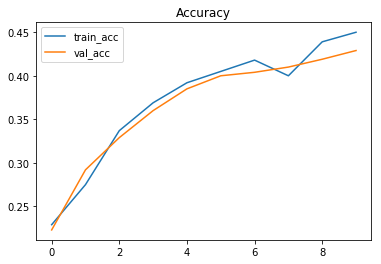

In [14]:
## TODO: plot the accuracy history
plt.title('Accuracy')
plt.plot(train_acc_hist,label='train_acc')
plt.plot(val_acc_hist,label='val_acc')
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [15]:
from utils.display_funcs import visualize_pics

num of feature vectors: 100


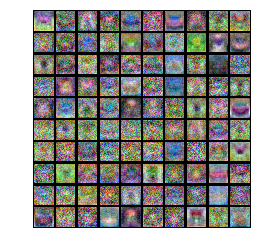

In [16]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 50%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 50%. If your accuracy is lower, for each 1% lower than 50%, you will lose 5 points.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.
6. Try use PCA or other preprocessing methods. (Try task3-dim_reduction.ipynb before finishing this task)

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<span style="color:red"><strong>TODO</strong></span>: See below

In [17]:
from utils.classifiers.twolayernet import TwoLayerNet
# TODO: Use previous layers to create a two layer neural network.
# Try several solutions and report the best performing one.
# input->(affine->activation)->(affine->softmax)->output
# The recommended activation function is ReLU. You can 
# make a comparison with other activation functions to see
# the differences.
#
# You will need to execute code similar to below, using your parameter specs:
#    model = TwoLayerNet(input_dim=TBD, hidden_dim=TBD, num_classes=TBD, reg=TBD, weight_scale=TBD)
#    num_epoch = TBD
#    batch_size = TBD
#    lr = TBD
#    verbose = TBD
#    train_acc_hist, val_acc_hist = train(TBD)
#    test(TBD, TBD, TBD)
model = TwoLayerNet(input_dim=3072, hidden_dim=800, num_classes=10, reg=1e-3, weight_scale=1e-3)

num_epoch = 20
batch_size = 100
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 490
2.403048844187146
27.333460809845615


D:\Course_Self\2019Fall\ECBM4040 Neural Network and Deep Learning\E4040_2019Fall_assignments\assignment1\e4040-2019fall-assignment1-xq2185-master\utils\layer_funcs.py:157: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(prob)[np.arange(N),y])/N


17.165858376061735
30.890451524374576
58.71133901138581
64.92631510997916
inf
inf
67.99660473459062
28.56185556992533
1000/49000 loss: 28.56212287545943
29.84449310241544
43.421891951553754
16.11031745837896
20.885662121475583
14.986700764147512
10.645061220683527
12.602288546738027
6.6269490194190075
7.953449460782286
8.865013027327906
2000/49000 loss: 8.865161600628898
4.480279959732907
4.955714121610891
3.9553792168019304
3.609208312244801
4.37104264933965
4.194158048879598
4.7483940900714225
3.368792375641583
2.917930323814989
2.8886666273656454
3000/49000 loss: 2.8887983314607535
3.929094626705049
3.584392174707576
3.22163910332689
3.4914521265662013
2.754788133572455
2.947323291803473
2.312587727725761
2.3654771784661723
2.340986487855213
2.296167571906533
4000/49000 loss: 2.296294554525961
2.4118118989313864
2.734496751887865
2.301391906700072
2.5129581063593274
2.3465471098423767
2.3037163001182086
2.1992019933356493
2.3799742046993884
2.289874900248718
2.583028179716824
5000/4

1.7886927899412433
1.6517196243548842
1.7407555761067348
1.6672919923260923
1.5756156719391283
1.7440579298019692
1.8422913996744028
1.7692822880598618
1.9339199288736788
38000/49000 loss: 1.9340617347985325
1.8667985731438619
1.839129793250494
1.8452135160320213
1.7037466586106245
1.8134162960394193
1.8172490672874366
1.763313388247072
1.7353416206705656
1.6344757192997685
1.6759575048771815
39000/49000 loss: 1.6760995807167804
1.6519021227722286
1.7590916530085743
1.5850915250689979
1.6749711937382654
1.7582708610220987
1.7999465588702486
1.7819764472753956
1.9355430788019632
1.8115338700820973
1.8608753286361122
40000/49000 loss: 1.8610181854487398
1.650036644286975
1.7034979121228806
1.6862675810503343
1.7302539766851452
1.688333197553332
1.903596155391065
1.7827186408123474
1.71769604294641
1.6330203837381603
1.7652147490949346
41000/49000 loss: 1.7653584184315647
1.7400314140758197
1.7507279555110982
1.7228293509983283
1.8491902865737584
1.7628963194369236
1.7981804543331745
1.63

1.486761705044462
1.5957874757846264
1.4080873929270128
1.6005928305865864
25000/49000 loss: 1.6007641107829633
1.7055064545094303
1.570790125134792
1.603960291917229
1.6336757075683994
1.61182249031437
1.7174221891878239
1.5521370159670096
1.6909884363950196
1.4668608406848724
1.7630279120717693
26000/49000 loss: 1.7631999595862566
1.5623387753419558
1.6978452671774051
1.4988022120943263
1.7609529945641358
1.4533118951901633
1.5532527091586643
1.4125881287707245
1.4945479345133537
1.4181730641059145
1.5983578620856966
27000/49000 loss: 1.5985309856493366
1.5560048900791636
1.3581263520041582
1.7496951615435643
1.6832700943042798
1.75713269829118
1.7290357612795373
1.5041221797109836
1.5568922086824384
1.6303365882460759
1.6100734406385877
28000/49000 loss: 1.6102470540710658
1.7919270006308379
1.3964670898958675
1.675052763953004
1.6789449217134094
1.643717761657529
1.6481359326919982
1.5405283629992892
1.5627955235369058
1.7208294140151046
1.4535392749330232
29000/49000 loss: 1.45371

1.650150188279638
1.515755828381767
1.4892144503031894
1.3739071556144153
1.5102325658023197
1.4283958850594316
1.5562232692922087
1.384907293028283
1.4883032979278878
13000/49000 loss: 1.4885073941654432
1.5087008627445468
1.3740634951699517
1.496768063253598
1.3876721760409847
1.4780399598955969
1.447291964111306
1.782130304721822
1.5467873354030013
1.4864064963591008
1.5185274309807693
14000/49000 loss: 1.5187323333487726
1.4171652944619744
1.488103559260874
1.4148315342080924
1.6718050370613946
1.3803357230504936
1.7595789279096052
1.3621395387344948
1.3833509640566002
1.4380313447898707
1.3829460082643485
15000/49000 loss: 1.3831518360801682
1.6187146050826564
1.604215903359782
1.2686356581854354
1.6047065866925063
1.6353996141650766
1.5158637009149272
1.4030837207550646
1.383681054081549
1.4450047579905936
1.521711731095626
16000/49000 loss: 1.5219184472176421
1.7399623227182404
1.3756672710718425
1.6001471929080429
1.611372610900811
1.4549888222985665
1.6689606078792179
1.443948

1.5723112724004298
1.4866612776624744
1.3591840299556626
49000/49000 loss: 1.3594207244844125
epoch 3: valid acc = 0.485, new learning rate = 0.0004286875
1.5317785490855298
1.500856925649839
1.493599245496059
1.4176902994288663
1.483302511163795
1.4898514787631896
1.3249945148792834
1.1560686956188366
1.5690586985375392
1.4459416989784877
1000/49000 loss: 1.44617941726687
1.4747853517876544
1.4247769774740238
1.373901780046946
1.3610454264736018
1.3204277573091425
1.6165725605628496
1.346226233323842
1.431040621573868
1.4165446977514993
1.2966779957381311
2000/49000 loss: 1.2969165456472724
1.5769418174795435
1.4673128782427978
1.389518709297913
1.4234532446458386
1.3702962516023698
1.3496603694674423
1.5611766347609914
1.4644423692484452
1.4139221827165493
1.4506819954469221
3000/49000 loss: 1.4509214623712123
1.3407375792804859
1.4020719452060058
1.2709942979056235
1.553292090720153
1.3860498539739574
1.403621855752472
1.3777633682288337
1.306935189138297
1.3160403830458463
1.314245

1.390013938566497
1.2357296932225936
1.4500677259863255
1.4321574183824919
1.1812495351900654
1.3970801201002445
1.559945047830444
1.3178025754137854
1.2872709065594312
37000/49000 loss: 1.287543170985058
1.262176384644051
1.4602761496453396
1.239102788235752
1.4849914560111932
1.3724840086547396
1.27698931722403
1.501137896334603
1.551473015130943
1.4272066008845612
1.2214986289283443
38000/49000 loss: 1.2217715616474494
1.3276797759403807
1.572974478953694
1.4267778627140029
1.3809825157667326
1.1392564199645248
1.1980712562312104
1.4001230501542432
1.3125810752146492
1.3091002916211836
1.0838265776558196
39000/49000 loss: 1.0841007960065592
1.5389848621639683
1.2825043767432274
1.3386970453602072
1.2872914025065243
1.3008705523811128
1.2797422719922964
1.334625243399127
1.299324406696172
1.2991781628870922
1.3318613439825469
40000/49000 loss: 1.332136872346993
1.2828901479254626
1.2552754697899875
1.4924652702506631
1.3127902796791766
1.4704195969643963
1.434758044411337
1.250325915

1.1991162418343118
1.3881453752030328
1.2838610756264976
1.2637662762579311
1.4801207070943831
24000/49000 loss: 1.4804278086003988
1.5645703054597928
1.2873385616751014
1.238330958274138
1.3231728565032186
1.3109256461329186
1.1969722485404288
1.22950816467879
1.4765123000602804
1.496726969014077
1.2519705244303787
25000/49000 loss: 1.252278409208062
1.2646327728316156
1.4924453911479052
1.4415590755774135
1.3840363871116128
1.3023774562548618
1.2632446096609187
1.3812635895441598
1.058118441218026
1.3227132588067756
1.3400584134141302
26000/49000 loss: 1.340367435428113
1.1850522467911317
1.2595633144984852
1.3674629029464673
1.374016059542766
1.4247566117744404
1.2984164916858603
1.4059472954586685
1.3655125105775952
1.4126920368423475
1.3904646203973547
27000/49000 loss: 1.3907743556164334
1.1013455792214832
1.362192538137768
1.3103057170746257
1.1060396482500625
1.3294694711799344
1.4098000794052166
1.2935488943167865
1.5583263754837815
1.2418778410008346
1.2172451678053415
28000/

11000/49000 loss: 1.4209842034383127
1.294529302891774
1.2846987022141931
1.3094826947509306
1.23915240363037
1.2476549669479156
1.3098945059525438
1.2909471880010415
1.2330303294759455
1.4284567278525835
1.1083884191715128
12000/49000 loss: 1.1087328940599954
1.2626470545307655
1.1829702641263753
1.3416107976923153
1.3359873569134997
1.308970241992879
1.5170138701956828
1.3180638984746278
1.3089336090250716
1.488584132963845
1.2802552557688134
13000/49000 loss: 1.2806005552723696
1.3805711588555172
1.1935945017893976
1.370203857774236
1.3784978124730036
1.2823779125964685
1.0806885060829468
1.3261744775166449
1.0692445562022979
1.0922593216738938
1.1632559066208776
14000/49000 loss: 1.1636024471367385
1.1745962134901164
1.2258920734467065
1.1913114507360225
1.3093609231389445
1.2753846741952628
1.540724475325471
1.2459202650455212
1.3276541913893427
1.1847229407515065
1.3389027481823215
15000/49000 loss: 1.3392503797008164
1.285872985381098
1.1090617115917498
1.0821301658302707
1.3187

1.3293662384150624
1.2329111678784441
1.2194031915025345
1.31637930605647
48000/49000 loss: 1.3167588952366995
1.147707848115711
1.0988881778977737
1.1714426911566176
1.08870399990458
1.15921331057454
1.3160850614871726
1.0162225442474822
1.3147903600219637
1.2187187255981287
1.2925464895662142
49000/49000 loss: 1.292927428921028
epoch 6: valid acc = 0.521, new learning rate = 0.0003675459453124999
1.2560321133961123
1.1644251009754996
1.0278511561629533
1.1985178269681187
1.236236979005505
1.2171154399830078
1.3929059456514792
1.2307953416840052
1.235025682283897
1.1245681149335995
1000/49000 loss: 1.124950300628025
1.1328488802221353
1.2144672448262985
1.1864998581068908
1.2007390463647831
1.353372357856475
1.5623969489095273
1.2866418555161245
1.178229337893783
1.2039189153036152
1.2769303713861433
2000/49000 loss: 1.2773133869110362
1.1549207116221394
1.3169563749606163
1.2240236597443168
1.083283435500797
1.1525984815515182
1.3229412967403675
1.4879625615732857
1.270854078736246
1

35000/49000 loss: 1.216145258293221
1.33636188583855
1.14243016521441
1.461562387830453
1.2257992589298108
1.2840648865307498
1.3949758054952737
1.1850836073479099
1.3418281658462512
1.2082413133154026
1.2766099636663122
36000/49000 loss: 1.2770282534150332
1.0982099363396154
1.1563855943077002
1.2659205938556872
1.1372312074259072
1.233769169804998
1.1553135852854095
1.1867901223439867
1.0853345291792054
1.3079173502135273
1.0733754821865762
37000/49000 loss: 1.0737949991735318
1.2554173518459026
1.0178664411084732
1.255481719546649
1.145540663528046
1.1743136873279711
1.1341776366163077
1.3119813957289619
1.1483408463099607
1.1406378818383902
1.1729522554263225
38000/49000 loss: 1.1733728805332118
1.3891982883744947
1.4243366116030978
1.1669361275072911
1.1311382166563255
1.1609653752242757
1.0356995957633854
1.2113961689008308
1.1648734578733912
1.2827608500228405
1.0868540015109862
39000/49000 loss: 1.087275900009357
1.2495853369261005
1.1720926253859212
1.1533804496773472
1.641673

1.196905141996839
0.9839754849840099
1.1486366082201125
1.2070918623092677
1.2864398166046607
1.3114493933878555
1.125422450238121
1.1699996317024153
23000/49000 loss: 1.1704535741916264
1.2384167928017644
1.0587352996606354
1.1703417008892474
1.1608563801710525
1.1472702597656994
1.3065064181065114
1.1907356973970955
1.2180609523246593
1.1150490952286385
1.026665170561869
24000/49000 loss: 1.0271203314203798
1.3733038669535813
1.1490297034095092
1.3064314910185713
1.2381946420389065
1.1569665840641656
1.1800768192723692
1.2912307782027699
1.2563768068535257
1.154050017469204
1.1931584000578475
25000/49000 loss: 1.1936147379675914
1.3208497002949335
1.115807271011151
1.193495932322564
1.1161088570906597
1.0982303254870274
1.2570900439587076
1.0952877044231182
1.1204178636630413
1.0793382553361277
1.2032115929997613
26000/49000 loss: 1.2036692671483877
1.2590474946949672
1.1340788419493153
1.3440765727643793
1.1568224511188987
1.1604055612002968
1.1897719045944901
1.2073738497457014
1.2

1.067768574003974
1.1477247347507786
1.204337162072693
1.2752734255220832
1.236820138846838
10000/49000 loss: 1.237312956981863
1.1230431740022107
0.9606047460552233
1.2256915996355529
1.0830141456690838
1.1685796649764422
1.0016985612909464
1.2641797153300267
1.2491155124903475
1.283179050554625
1.0621849669751564
11000/49000 loss: 1.062678794750884
1.0324903331996247
1.111468537919298
1.197348265408121
1.115618157966481
0.9988785327123191
1.1871093636356829
1.0674204621389487
1.173756336549776
1.1842811743237291
1.2883719493040118
12000/49000 loss: 1.2888669511961353
1.199788747739138
1.2009831655706804
1.062567716407319
1.1694988100975268
1.1015260229886363
0.9768635380765904
1.3247916592390698
1.174905848841577
1.2429317981664534
1.023391148814576
13000/49000 loss: 1.0238871085305115
1.0352490521428093
1.102028872734728
1.2518025474088963
1.2314504966888122
1.365800713201747
1.0770486087667177
1.0867124898468885
1.0064650807937892
1.3104559100938848
1.0986214277350619
14000/49000 l

0.9448909098128035
1.19910236832491
1.0961014558378264
1.1309594071173452
1.305395923987285
0.970890108014491
1.1173164341224753
1.0904742575717612
1.0577713565930478
47000/49000 loss: 1.0583037393600405
1.1288194590887306
1.3773060815671667
1.1869028171683644
1.1371825855269972
1.085688944395217
1.0309445454069361
1.342405988202012
1.0990151182453942
1.1952983287277243
1.1270890319604125
48000/49000 loss: 1.1276222324953573
1.1445297620595136
0.9870062718979722
1.186949686166688
1.1219603044190705
1.0817921341271002
1.1345855714908801
1.0512004689362016
1.0890110542562124
1.1976176713541278
0.9829858171532087
49000/49000 loss: 0.9835202379715752
epoch 9: valid acc = 0.516, new learning rate = 0.0003151247048623045
1.2432005224057967
1.1761967721672728
0.9917775750958963
1.4887792300280807
1.0250470815636827
1.179752833685579
1.0377043758325244
0.9351520618011423
1.2276579554074023
0.8354206688740817
1000/49000 loss: 0.8359559474522759
1.2897979148594139
0.9771162050990694
1.1900731020

1.0310679180918787
0.9396932343705494
1.1705533417814384
1.1026446695328815
1.2283766235323856
1.1632152409647538
1.0486108621868668
34000/49000 loss: 1.0491802146322395
1.028911006758595
1.0720261176169732
1.1933499942285615
1.275208533512071
1.1019523706754348
1.1340587186217141
1.044115845306169
0.9187519377178245
1.2849540137477786
1.1045964613141053
35000/49000 loss: 1.105166862832713
1.055279337593153
0.8900728624251606
1.1478300069879814
0.9752937029767982
1.1262017341713564
1.0952032649527246
1.351721073469254
0.9679345260338366
0.9176979814282865
1.0390521390252636
36000/49000 loss: 1.0396236607606109
1.265196352021565
0.9903932515264782
0.951491771235791
1.204008002248017
1.1252897166586247
0.8469934775299502
1.2306150957866107
0.993882636103796
1.2424021553158986
0.9902155638979231
37000/49000 loss: 0.9907881170735292
1.0762164157721101
1.118193967716158
1.0635477048105937
1.0057823418908833
0.9186906168003379
0.9079883950513848
1.1204515360040048
1.1480839167358001
1.115214

1.2561163522552226
1.2001993163283042
21000/49000 loss: 1.2008071631502415
1.1165195680802114
1.1624496453471869
1.1353541549868162
0.9756789903329135
1.0741213061628598
1.1377563570061533
1.0893411122362389
1.029887489015295
1.0163560707269428
0.9965069775862662
22000/49000 loss: 0.9971159545107425
1.1937640870849824
1.1439586771638282
1.016517878942911
0.9464235195205315
0.8650919111128081
1.1130694310719458
1.1752459478051
0.9673965340277094
0.8915752140012674
1.1983690434903582
23000/49000 loss: 1.1989793159692537
1.0941978877726009
1.0957530584928654
0.8522941139387527
1.1894263101979448
0.8504332235979238
1.0082521048373945
1.0887410513501468
1.2905176243375405
0.8648496975808636
1.1631729130876125
24000/49000 loss: 1.1637842893928223
0.9504148160546593
1.0581093231263707
1.1681443943243581
1.020662580717339
0.9453125857975969
1.0980982336528728
1.1245129172071275
1.0490418312846557
1.1162044785747538
1.1082721716934845
25000/49000 loss: 1.1088846858421237
0.9086879801811246
0.89

0.9811908384638517
8000/49000 loss: 0.9818373694167712
0.9060584010501946
0.9725532279981186
1.0314589196396637
0.9374738876339819
1.018215593295799
1.1298099641763897
0.944676537196058
1.159598157000084
0.9883583146339154
0.8863734236879525
9000/49000 loss: 0.8870211862630627
1.1192667438965886
1.2217390445812732
0.9901530175473491
0.9400855155238241
0.9867799238502718
0.8873151298315208
1.1039587281701602
1.1087691007067524
1.0270231441661501
1.071103130687183
10000/49000 loss: 1.0717518805977764
1.025325462019264
0.8929367286313257
0.9377992483933285
1.1015521822478669
0.9180900520119097
1.2780645787187934
1.111760199634022
0.9529047005234643
1.1812515711649596
1.1040321882763398
11000/49000 loss: 1.1046818264166134
1.003179071706511
1.1274437788373017
1.030724101256554
0.9304937903944809
1.22130703122954
0.9878136650815965
1.0199955512845478
1.030099860791199
0.9087065435940319
1.1154903381495578
12000/49000 loss: 1.1161410204422553
1.1105261139950158
0.9281250147195408
0.993473659

1.0749060509736048
1.0282011205082529
1.1157652255154553
0.816947546980988
0.9217662937058195
0.8408117148989527
0.7627655327579704
45000/49000 loss: 0.7634516271636698
1.020735969825425
0.9163787802468891
0.8169009068804065
1.068222264537256
0.9163528199366092
1.022860581182018
0.9528552842485856
0.9932960058312585
0.9706801964693696
1.0418864056705495
46000/49000 loss: 1.0425738940163611
1.007930620807977
0.9058344115217699
1.1670061557192253
0.8182569910380768
0.9191707576144812
0.9942661003648056
0.9361770023716849
0.8944617441686796
1.210257319874176
0.9167912224695677
47000/49000 loss: 0.9174798429045625
0.9333397780600768
1.0418681052303809
0.9469964003501823
0.9773487915179631
1.1707150106503916
0.9177442516535486
1.0379029032542941
1.0453592333291843
1.0893221427336781
0.9240102822680386
48000/49000 loss: 0.924700001338022
0.7830653563137103
0.9217917966189607
0.9843876862597891
0.8230566320103531
1.0125816017432354
0.9642323350508555
1.0482936161774916
1.0568488570094217
0.84

0.9045170893039652
0.7915458213799269
1.0066980976014606
0.9398106654101364
1.1356501832618682
32000/49000 loss: 1.1363747878932136
0.9795078471180869
0.908580358460978
1.2052241182842574
1.1886873893051344
1.0361009594331247
1.053269623268754
0.930687682559704
0.942299091680203
0.9992973839357674
0.9411347458577578
33000/49000 loss: 0.9418603570991855
0.8955980413497205
1.2157504883284151
1.017538649774286
1.0770045802421164
0.9649696271939824
0.7977570619351286
1.0593091818592486
0.9101383512054965
1.0499879721246685
0.8955897415394785
34000/49000 loss: 0.8963165484864947
1.0136099441490896
1.0836560705113858
0.8984704111690327
1.0874827053502052
0.8290419681206026
0.8486225256228846
1.0432453740690557
0.8654267020285437
0.8968859833268855
1.0349268326459136
35000/49000 loss: 1.0356547985024438
1.0168840344826755
1.064776371997529
1.0177034587551688
1.177961232834492
0.8629201369805561
1.095070662330512
1.0218366909952628
1.1404400646454602
0.8703896406567238
0.957917321122836
36000/

0.9915994428938391
0.9462521349564703
1.0062779077459603
19000/49000 loss: 1.0070400664175558
0.9553997505587455
1.0333286926218632
1.121918837699785
0.9357094759537112
0.8683746670929305
0.8963935297311448
0.7933105874348293
0.8091416582965206
0.9785862275451617
0.94449187325949
20000/49000 loss: 0.9452552036887086
0.8662895577179551
0.9371088233359107
1.1227530561699068
0.8985371641305288
0.9468569650051114
0.929870709008555
1.1147088718931513
1.0034031510839676
0.9013045879201778
0.954177455794795
21000/49000 loss: 0.9549418401951587
0.9850968370414112
0.9017487312093507
1.1331207382571704
0.828125281072748
0.9126222921963739
0.9071514494724104
1.0682251824044535
1.1943527695525618
0.9628070907961718
0.9563681587972916
22000/49000 loss: 0.9571333620764596
0.9203676677369158
0.8779212464110893
0.8868672544542032
0.7990892140131928
0.9900866714905701
1.1361955830167212
0.8340733295133805
0.9149218741984523
0.8941380711785415
1.00833809889926
23000/49000 loss: 1.0091044986308102
0.9675

6000/49000 loss: 1.0585165616822616
1.2265085208812219
1.0337627978187798
0.9631958594767747
0.8465378841836051
0.9072158489658065
0.945050487381653
0.9872414083029695
0.8286843892819076
0.890632371989117
1.0488259136771072
7000/49000 loss: 1.0496263243562822
0.8732734953793977
0.7787615735836307
0.8903837231693217
0.8611523606108006
0.781867856711282
0.8962672966086926
0.6556786206055689
0.8915909073445623
0.8959113746767905
0.9156535670482168
8000/49000 loss: 0.9164551316055292
1.304983716322941
0.9468641271413266
1.0597881900815704
0.8492542763054337
1.0428595041357844
0.9109534161457978
0.890250075679499
1.0185795617702198
0.952672204431056
0.8956557798156375
9000/49000 loss: 0.8964581245098512
0.8147064389890256
0.8439961497575408
1.0774108804161564
1.2164476891290608
0.909869947471905
0.9334910425889476
0.9821816640927428
1.0158524578991106
0.809536697006573
1.2036889576993148
10000/49000 loss: 1.2044922655756114
1.0093211110807077
0.9793472583796222
0.8744936314697427
0.96918047

0.9993698787435626
0.9536930491773461
0.911846232102912
0.8936532859574764
0.8526122036584033
1.0203386040875095
0.8446540620426093
43000/49000 loss: 0.845492231539103
0.9549650245516987
1.0003351180504831
0.9764876500267147
0.9070870422517403
0.8596729830213984
0.8828440690504762
0.9252566031656819
0.8451006672368018
0.9208897957742505
0.739631818473993
44000/49000 loss: 0.7404710949791657
0.9763691875468572
0.9714946161151786
0.8937238575824726
0.9047650231231966
0.9937021317389875
1.0101946340759538
0.9697970585008636
0.7785011960176127
1.025923561452432
0.7688426196612604
45000/49000 loss: 0.7696829406320168
1.0284069904242277
1.0037782438965692
0.8018018877526647
0.9949047092062547
0.85713288490868
0.9320588211244483
0.8941715924276221
0.8508019515430705
0.9298245502418115
1.0750228656226937
46000/49000 loss: 1.075864132040497
0.8219324177854453
0.9624948977956309
0.8419763202177094
0.9658274224246115
0.8910707926165646
0.9310607194482573
1.1690190672049667
0.756682925037362
1.051

1.0522701226133737
0.9629400330183796
0.8841381305554918
0.9607613660417317
0.9020199782222165
30000/49000 loss: 0.9028942933580257
0.8611614829450785
0.9349837669571862
0.735845255597559
0.781619856437795
0.9155890581575705
0.7406782592537611
0.7817517714469896
0.8543255874954119
0.9126957686774887
1.074181632795761
31000/49000 loss: 1.0750571193021181
0.8944089141637224
0.9529870637889782
0.8680023718686091
0.7771170799917335
0.9256888262242934
0.8901476888358326
0.8719776551774094
0.9315893940490875
0.9315366353959407
1.0098489231843082
32000/49000 loss: 1.0107255166724551
0.7257160567720728
0.9433063883871685
0.8036972002350986
0.8654556549211431
0.833326416588681
1.01528022907441
0.9361519350863655
0.955875014641207
0.8106161934824181
0.8708051184957759
33000/49000 loss: 0.871682698240651
0.6540595869342998
0.9061982866292595
0.9330676988854038
0.8433109315187289
0.893150044161525
0.843080910546076
0.9653727776053194
0.8995022786763484
0.8300509656479739
1.0686247580553487
34000/4

1.0898604480964778
0.9198652412045201
0.8232826043569607
17000/49000 loss: 0.8241944040225222
0.7251802084627944
0.8441533253275441
0.7616983406736177
0.8715990629762567
0.9082585360589713
0.7611894935353619
0.7965153114496161
0.8787098024780938
0.902308585267107
0.8579194291194563
18000/49000 loss: 0.8588323282604731
0.9825147407293577
0.8831352194059973
0.8560715973100415
0.7779726868031096
0.7475163407275182
0.9666848944704644
0.875152956692081
0.8437754821280129
1.0207152960920722
0.8195735075828405
19000/49000 loss: 0.8204873825464056
0.9136292935624742
0.7817581533388279
0.8656123828588125
0.7882116327693521
0.9287437551117038
0.7624775661802259
0.9281754683628791
0.8636878565656881
0.8385253851402348
0.7628873320043361
20000/49000 loss: 0.7638023634964254
0.8085042483172776
0.8328517376061462
0.7949641784991934
0.9951734651747967
0.9299566885505374
0.981031107121687
1.0230868142444178
0.9078022526453584
0.8268679515470846
0.8162047752465152
21000/49000 loss: 0.8171207296643541
1

0.776756523190043
0.8983531859997769
4000/49000 loss: 0.8993017076868445
0.7783809374720831
0.7147388898468491
0.8118181908832663
0.9482546304679712
0.8329113394371142
0.7919180042645185
0.8966489042693504
0.9352262421178225
0.8063967444788105
0.9202699531540052
5000/49000 loss: 0.9212194966632843
0.6688894700383698
0.8338684729295633
0.7451530289644009
0.7813735063046106
0.8580524539952684
0.6708215148575779
0.990255885923912
0.7755369514905941
0.6307455858886827
0.8103235271956329
6000/49000 loss: 0.8112742106577191
0.9375732244914442
0.7899964502924297
0.7879190828630687
0.8823381913880217
0.613878569660688
0.8023281452767754
0.912512447295626
0.6296902802661714
0.7253317083299549
0.83105918030634
7000/49000 loss: 0.8320108585991246
1.0498704622597435
0.7661149457337518
0.9927285946022626
0.8046306635028347
0.7904053412654483
0.7852029780046531
0.6683375984992659
0.6982638604531877
0.7721711563640818
0.9032524709362771
8000/49000 loss: 0.9042051952063722
0.6931943919080946
0.8928443

0.81145570116697
0.7256105348458428
0.9071390717462704
0.9420747175580039
0.8675988406968927
0.9023371472262725
0.7147622036820587
0.8317974558281596
41000/49000 loss: 0.8327829167840345
0.7471349136729453
0.7654848998845506
0.7704141627357258
0.7921071707163536
0.7498521337946085
0.7803366625342845
0.7211477773070546
0.7502529239152146
0.7463996292739802
0.9388343115960303
42000/49000 loss: 0.9398208890021156
0.8741773261751961
0.8976416641711813
0.9059755454852337
0.6965414484156679
0.7038574033677863
0.6944236667503045
0.7439583124269424
0.7269548977046422
0.9089221193611577
0.7888426441308921
43000/49000 loss: 0.7898303082264402
0.7592289994440802
0.7735228946229832
0.8239047467575346
0.8861326267397707
0.8909802096064798
0.8519758189890183
0.9316173338703151
0.9457702604410523
0.9481500820859927
0.6933888351310575
44000/49000 loss: 0.6943774271694971
0.7158602008205606
0.7646275498413263
0.9105323915723144
0.7364700129511033
0.8397694563781667
0.6149698348417697
0.8605003283564148

0.7320508775874736
0.8089517310626166
0.7274239049790228
0.8576160926384472
0.8503319781839217
0.9451122609525108
0.7792675188180183
0.8313403942228803
28000/49000 loss: 0.8323607178236505
0.7648172220564097
0.6844851574753524
0.9141024677150139
0.7748808076034553
0.7368006423629629
0.7557892787082439
0.8722214145282919
0.7842373185255949
0.7633204966907914
0.6617582922580647
29000/49000 loss: 0.6627796036314196
0.7487909181277252
0.8795149055172067
0.8887231040811358
0.9990763526179162
0.8180126091957824
0.8253054593439547
0.6471296690011751
0.8528655050237163
0.9544991714200421
0.7213008939664433
30000/49000 loss: 0.7223231004665674
0.6781694388361487
0.8018272267760755
0.7283533322247231
0.9285016806290295
0.9561607858420291
0.8557825749705238
0.8143041073046221
0.759410041980247
0.727976866475331
0.9276189742862067
31000/49000 loss: 0.9286421708471749
0.85792289058749
0.8063834478035341
0.8481569578993199
0.9065714245563029
0.6348562751995639
0.841447507500515
0.9024595633158067
0.

0.8180785829111866
0.7491758457745016
0.6247838916557229
0.7144987773166848
0.8339303516367917
0.8939000348888027
15000/49000 loss: 0.8949549661231512
0.8894072347418982
0.7467167252111854
0.71774594887889
0.8802473925483608
0.7395261170702766
0.7263219215319743
0.6916940079890348
0.8434529635325141
0.7643962107107621
0.7374715014402117
16000/49000 loss: 0.738527315736119
0.6849479989797778
0.6481199430704518
0.7191281365056662
0.8323406991884077
0.857343536475083
0.7179622497693663
1.0528685805150564
0.7538809581281322
0.7596868176102292
0.7839061550023371
17000/49000 loss: 0.7849630476198276
0.8393409054830427
0.7402322613449313
0.6773309449448627
0.8187533643180632
0.6986290461484072
0.8029377242028631
0.740668285510826
0.7007935762439257
0.8072757864670129
0.6556902129863978
18000/49000 loss: 0.6567480744476146
0.6797037910602188
0.8386627814515221
0.7464331673393144
0.5551073025861285
0.718412826644989
0.7715357426731575
0.722557125506533
0.9914500578692085
1.0419305134854415
0.69

0.5327

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

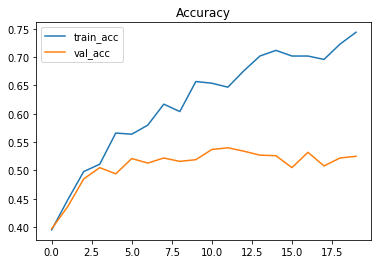

In [18]:
## TODO: plot training and validation accuracy
plt.title('Accuracy')
plt.plot(train_acc_hist,label='train_acc')
plt.plot(val_acc_hist,label='val_acc')
plt.legend()
plt.show()

num of feature vectors: 800


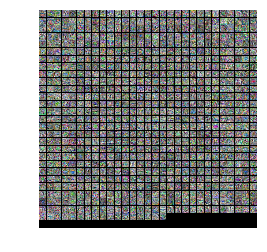

In [19]:
## TODO: Visualize weights
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Save your best model in a dictionary 

In [20]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
## A template of loading your model
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Net 

Complete the class **MLP** in **./utils/classifiers/mlp.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete the class **MLP** in **./utils/classifiers/mlp.py**

In [25]:
from utils.classifiers.mlp import MLP

## TODO: Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
2.3027999038260862
2.291736327910782
2.2806905830835977
2.2739197195683603
2.27892301847148
2.2873440758389916
2.2753507060283056
2.291621559155017
2.2914006397837055
2.2739248938070507
2.284892770417797
2.278775172643296
2.261674409534668
2.309365686544277
2.2631295227029997
2.2839700219836496
2.291262176481837
2.2691747049160185
2.284385062558784
2.2784006012749987
2.2753898039650484
2.2673310909390394
2.266505058890554
2.257920249232515
2.2581972668902943
2.2710437342299694
2.2722460655109913
2.2551311568340178
2.2825339954218
2.2671677628807116
2.2858230197559806
2.258357048101936
2.2892656587098283
2.2756456562214518
2.2676801131496926
2.2726967209750715
2.285667546094898
2.250456056450852
2.250283744691161
2.286082567474565
2.2782334304468503
2.2727828649071244
2.2475348867504987
2.2733924695134475
2.2551325328251637
2.2503177528971623
2.266552601431747
2.2459004938964844
2.285644186945491
2.2794097316192072
2.2434747185579216
2.25508889396794
2

1.8626549739054072
1.8295158835340966
1.893251624849498
1.8425131067248626
1.8527165357421795
1.8430090005277777
1.8772727253736547
1.8425279205522316
1.8740867889212618
1.8924186972168182
1.8610964691661929
1.8419247865159059
1.858736703403627
1.7983166444781238
1.8188359463724264
1.851501405453671
1.8437696429322836
1.84389833715727
1.7832282983815877
1.8800872992404811
1.903760543414879
1.846150900317553
1.8610908703010427
1.8373670334164804
1.8523321950905238
1.8625090305934793
1.8408710727229292
1.8510825329191603
1.8938029878433753
1.9335328226049193
1.8703169388001393
1.8340077643148174
1.8295943961480416
1.7994664262254196
1.856240876830117
1.8317760426403955
1.814779375846922
1.869605342232157
1.8059554258246908
1.8502300850628886
1.826712948795661
1.7759221851746823
1.8056423012610836
1.8508847290909944
1.8569067919673932
1.827737269457489
1.825007252826017
1.832265162959163
1.815494436024258
1.783957621335802
1.8068946598408824
1.8366252749974967
1.8359033317800482
1.8399789

1.573350076055675
1.539457093164333
1.5516144359569102
1.5124736817350959
1.578763307889764
1.5263593587461772
1.4987956791962493
1.493656718787069
1.5732875900527976
1.5525770767556393
1.5992703777208472
1.6163231140773504
1.5553431232898447
1.4959779668105149
1.5544165801922365
1.5419355576028437
1.586480057329557
1.5555168327051037
1.5337407130279823
1.6575443719713658
1.6909547103019287
1.59490187484574
1.5091304232975484
1.5933963561720939
1.6763104523104047
1.6362784473674834
1.6043077718797578
1.5595170444589976
1.5821431450479417
1.5653005982751507
1.5426414255583505
epoch 9: valid acc = 0.416, new learning rate = 0.006302494097246091
1.6105283345198804
1.5382365973612349
1.6088267860432701
1.6077590520773792
1.6395785281274398
1.5072316957649319
1.5799014016246573
1.5629511438862789
1.5692747956981283
1.512021103765068
1.5464115881840943
1.5080852923048516
1.5643740523139094
1.5593202636269727
1.5588002912866423
1.5535109222147432
1.5774979900215267
1.51732831965428
1.59401067

0.4349

## Part 4: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 or 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

tf.reset_default_graph()
# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
        self.b2 = tf.Variable(np.zeros((10,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= out, labels=tf.one_hot(targets,10))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss 

# calculate gradients and do optimization
def step(model, inputs, targets, reg = tf.constant(0.01)):
    loss_value = loss(model, inputs, targets, reg=reg)
    return tf.train.GradientDescentOptimizer(1e-3).minimize(loss_value)

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.argmax(model(inputs),1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 10
with tf.Session() as sess:
    model = Model()
    x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
    y_tf = tf.placeholder(tf.int64, shape=(None,))
    train_step = step(model, x_tf, y_tf)
    accuracy = eval_acc(model, x_tf, y_tf)
    init = tf.global_variables_initializer()
    sess.run(init)
    for e in range(num_epochs):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
    print('test acc = {}'.format(test_acc))

Instructions for updating:
Colocations handled automatically by placer.
epoch 1: valid acc = 0.27399998903274536
epoch 2: valid acc = 0.31299999356269836
epoch 3: valid acc = 0.3140000104904175
epoch 4: valid acc = 0.3709999918937683
epoch 5: valid acc = 0.39800000190734863
epoch 6: valid acc = 0.3959999978542328
epoch 7: valid acc = 0.4230000078678131
epoch 8: valid acc = 0.4339999854564667
epoch 9: valid acc = 0.45100000500679016
epoch 10: valid acc = 0.46700000762939453
test acc = 0.45159998536109924


### More layers

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" or "dictionary" to store your network parameters, ie., self.W and self.b. Besides, consider to use a loop to create your MLP network.

In [ ]:
## For example
#self.W = {
#    'w1': tf.Variable(),
#    'w2': tf.Variable()),
#    'w3': tf.Variable()),
#    'w4': tf.Variable()),
#    ...
#}

In [10]:
## Demo: Two-layer net in tensorflow.
input_dim = X_train.shape[1]
output_dim = 10
hidden_dim = [100,2000]
reg_tf = tf.constant(0.01)
scale = 1e-2

tf.reset_default_graph()
# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(3072, hidden_dim[0]).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim[0],)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim[0], hidden_dim[1]).astype('float32'))
        self.b2 = tf.Variable(np.zeros((hidden_dim[1],)).astype('float32'))
        self.W3 = tf.Variable(1e-2*np.random.rand(hidden_dim[1], 10).astype('float32'))
        self.b3 = tf.Variable(np.zeros((10,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.W2) + self.b2)
        out = tf.matmul(h2, self.W3) + self.b3
        return out

# Define and calculate loss function
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= out, labels=tf.one_hot(targets,10))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2) + tf.nn.l2_loss(model.W3)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss 

# calculate gradients and do optimization
def step(model, inputs, targets, reg = tf.constant(0.01)):
    loss_value = loss(model, inputs, targets, reg=reg)
    return tf.train.GradientDescentOptimizer(1e-3).minimize(loss_value)

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.argmax(model(inputs),1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 10
with tf.Session() as sess:
    model = Model()
    x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
    y_tf = tf.placeholder(tf.int64, shape=(None,))
    train_step = step(model, x_tf, y_tf)
    accuracy = eval_acc(model, x_tf, y_tf)
    init = tf.global_variables_initializer()
    sess.run(init)
    for e in range(num_epochs):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_test, y_tf: y_test})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.0860000029206276
epoch 2: valid acc = 0.10999999940395355
epoch 3: valid acc = 0.10999999940395355
epoch 4: valid acc = 0.11400000005960464
epoch 5: valid acc = 0.11500000208616257
epoch 6: valid acc = 0.1080000028014183
epoch 7: valid acc = 0.08900000154972076
epoch 8: valid acc = 0.07800000160932541
epoch 9: valid acc = 0.07699999958276749
epoch 10: valid acc = 0.07100000232458115
test acc = 0.08820000290870667
